<a href="https://colab.research.google.com/github/williamokomba/Flower-classification-using-EffientNet-Transfer-learning-RES/blob/main/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Image  Classification using EfficientNet Transfer learning

1. load using API token from kaggle
2. visualize the images
3. data augmentation
4. train test split
5. building EfficientNet model
6. prediction and evaluation


About Dataset

Context

This dataset belongs to DPhi Data Sprint #25: Flower Recognition. The dataset contains raw jpeg images of five types of flowers.

* daisy
* dandelion
* rose
* sunflower
* tulip

Content

* train - contains all the images that are to be used for training your model.
  In this folder you will find five folders namely - 'daisy', 'dandelion', 'rose', 'sunflower' and 'tulip' which contain the images of the respective flowers
* test - contains 924 flowers images. For these images you are required to make predictions as the respective flower names - 'daisy', 'dandelion', 'rose', 'sunflower' and 'tulip'
* Testing_set_flower.csv - this is the order of the predictions for each image that is to be submitted on the platform. Make sure the predictions you download are with their image's filename in the same order as given in this file.

In [6]:
#import dependences
from zipfile import ZipFile
import os
import cv2
#!pip install imgaug
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0 # Fixed the typo here
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
#uploading data directly from kaggle
# Create API key
#install kaggle library
#!pip install kaggle


In [8]:
#configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

[flower dataset kaggle link](https://www.kaggle.com/datasets/imsparsh/flowers-dataset)Import flower dataset api

In [9]:
#API to fetch the dataset from kaggle
!kaggle datasets download -d imsparsh/flowers-dataset

Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
 92% 188M/205M [00:01<00:00, 166MB/s]
100% 205M/205M [00:01<00:00, 170MB/s]


In [10]:
#extracting the compresed sentiment dataset
from zipfile import ZipFile
file_name = "flowers-dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [11]:
#Rename train to flowwrs and Create it base Directory
#import os
os.rename('train', 'flowers')
datadir = '/content/flowers'
Categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

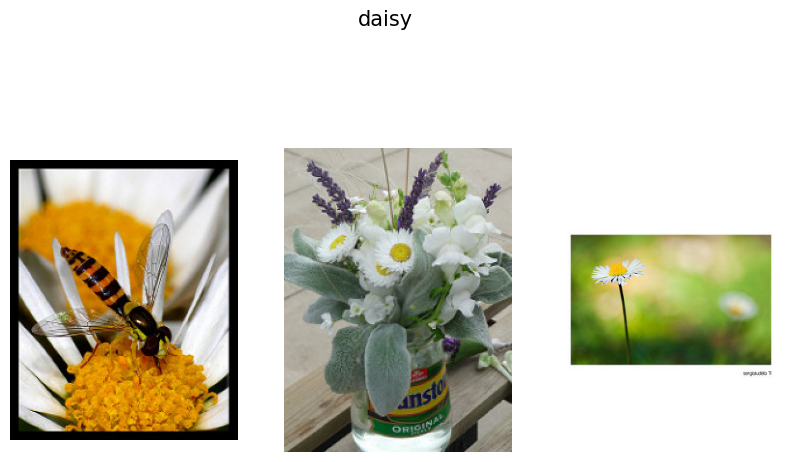

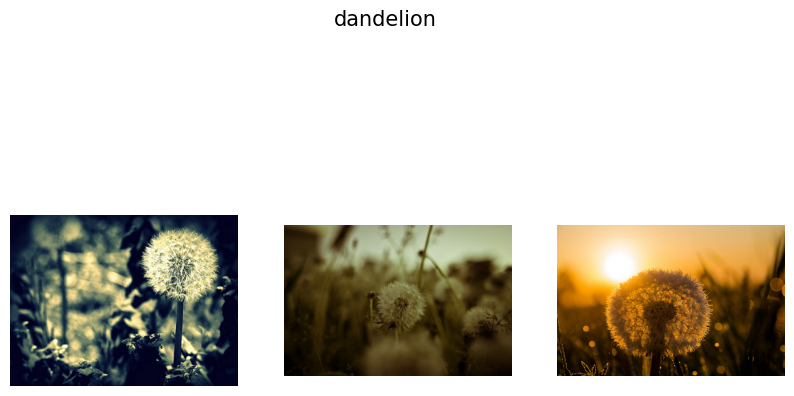

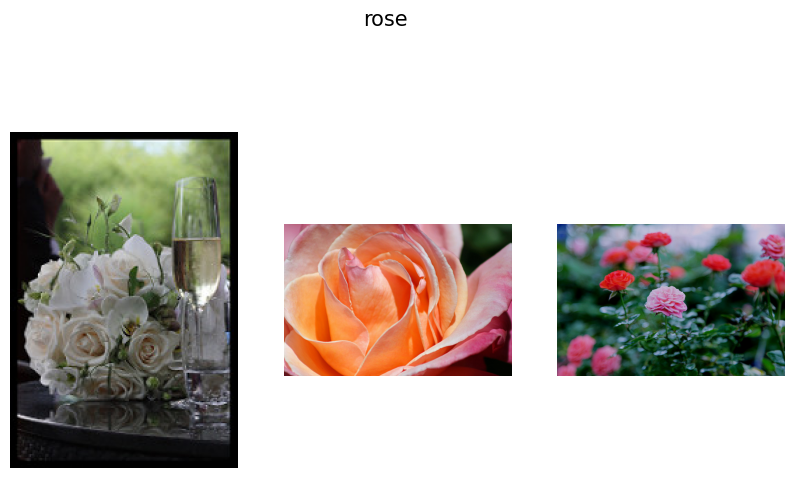

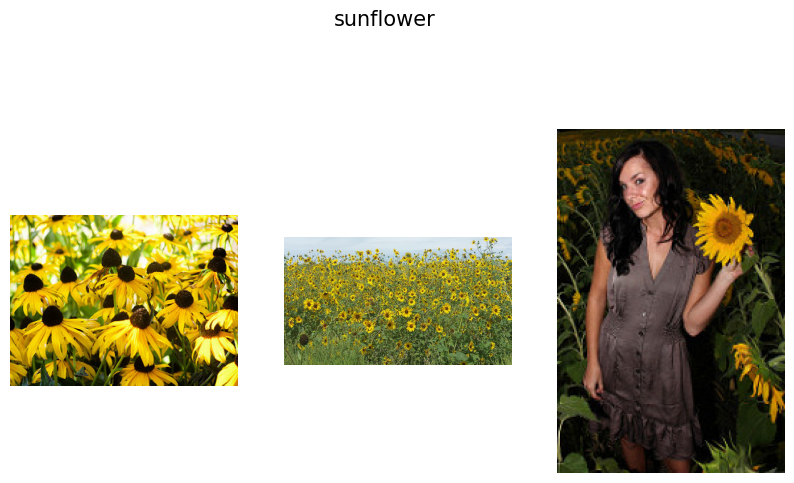

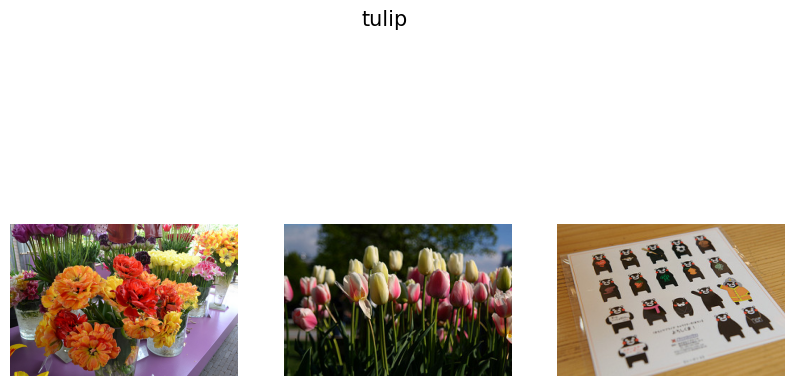

In [12]:
#Display the random images from each folder
for category in Categories:
    path = os.path.join(datadir, category)
    imgs = os.listdir(path)

    fig, axes = plt.subplots(1, 3, figsize=(10, 6))
    fig.suptitle(f'{category}', fontsize= 15)   # Use suptitle to set the figure title

    # Iterate over the 3 random images in each folder
    for i in range(3):
        img_name = imgs[np.random.randint(0, len(imgs))]
        img_path = os.path.join(path, img_name)
        img = plt.imread(img_path)

        #Read the images from the path
        image_array = cv2.imread(img_path)

        #convert BGR to RGB color format
        image_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

        #show image
        axes[i].imshow(image_rgb)
        axes[i].axis('off')

    plt.show()

Image Augmentation

Data augmentation increases the accuracy of the model

In [13]:
#Creating a function to count images in each folder to ensure that augmentation took place

def count_images(directory):
    for category in Categories:
        path = os.path.join(directory, category)
        num_images = len(os.listdir(path))
        print(f'{category}: {num_images} images')

In [14]:
#count original images in each category
count_images(datadir)

daisy: 501 images
dandelion: 646 images
rose: 497 images
sunflower: 495 images
tulip: 607 images


In [15]:
#data augmentation
aug = iaa.Sequential([
#horizontal flips
iaa.Fliplr(0.5),
# randomly croping images upto 10% os it's size
iaa.Crop(percent = (0, 0.1)),
# scaling the image between 80% and 120% and rotating it between -25 to 25
iaa.Affine(scale = (0.8, 1.2), rotate = (-25, 25)),
# changing the brightness of the images
iaa.Multiply((0.8, 1.2)),
# adjusting the contrast of the images
iaa.LinearContrast((0.75, 1.5))
])

#create a function to augment the images
def augment_images(directory, Categories):
    for category in Categories:
        path = os.path.join(directory, category)
        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented_img = aug.augment_image(img)

#create a new file to hold uagmented images and then add them to original folder
            new_filename = os.path.splitext(filename)[0] + '_augmented' + os.path.splitext(filename)[1] # Indent this line to be inside the loop
            cv2.imwrite(os.path.join(path, new_filename), augmented_img) # Indent this line to be inside the loop

#apply the function to all the images
augment_images(datadir, Categories)

In [16]:
#check the new total images
count_images(datadir)

daisy: 1002 images
dandelion: 1292 images
rose: 994 images
sunflower: 990 images
tulip: 1214 images


#### Resizing the images to 224

In [17]:
#Resizing the images to 224
#Current size
image_array.shape


(213, 320, 3)

In [18]:
#Resize to 224
IMG_SIZE = 224
new_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
new_array.shape

(224, 224, 3)

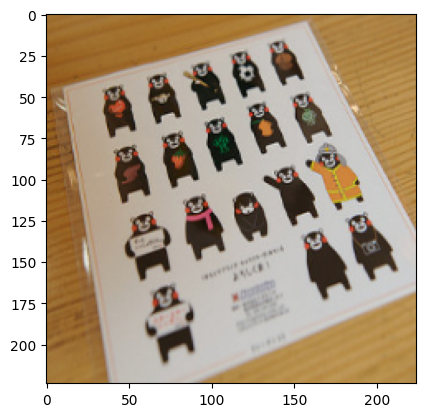

In [19]:
#visualize
#change to rgb
new_array = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
#visualize
plt.imshow(new_array);

### Create Training data

In [20]:
#creating training data and target

training_data = []

def create_training_data():
    for category in Categories:
        path = os.path.join(datadir, category)
        labels = Categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, labels])
            except Exception as e:
                pass

create_training_data()

In [21]:
#check training data
len(training_data)

5492

In [22]:
#separate feature and target variable
x = []
y = []

for features, labels in training_data:
    x.append(features)
    y.append(labels)

#check the data type
type(x), type(y)

(list, list)

These are list. model work better with array. thus we will change to array

In [23]:
#convert to array
x = np.array(x).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [24]:
#split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [25]:
#check the shape for train and test data
print(f"X-train length: {x_train.shape[0]},\
X-train image size: {x_train.shape[1:3]},\
channel dimension: {x_train.shape[3]}" )

print(f"X-test length: {x_test.shape[0]},\
X-test image size: {x_test.shape[1:3]},\
channel dimension: {x_test.shape[3]}" )

X-train length: 4393,X-train image size: (224, 224),channel dimension: 3
X-test length: 1099,X-test image size: (224, 224),channel dimension: 3


In [27]:
#Building EfficientNet model
effinet_md = EfficientNetB0(weights = 'imagenet',
                            include_top = False,
                            input_shape = (IMG_SIZE, IMG_SIZE, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
#Freezing the bottom layers
for layer in effinet_md.layers:
    layer.trainable = False

In [29]:
#Creating fully connected(Dense) Layers

model = keras.Sequential([
    effinet_md,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu'),
    Dropout(0.2),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(256, activation = 'relu'),
    Dropout(0.2),
    Dense(5, activation = 'softmax')
])

#compile the model# use sparse cat crosentropy when whe have not encoded
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

#Train the model
history = model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data = (x_test, y_test))

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.7313 - loss: 0.6830 - val_accuracy: 0.8872 - val_loss: 0.3357
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.9094 - loss: 0.2400 - val_accuracy: 0.8963 - val_loss: 0.3258
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 457s 3s/step - accuracy: 0.9413 - loss: 0.1644 - val_accuracy: 0.8981 - val_loss: 0.3138
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 555s 4s/step - accuracy: 0.9578 - loss: 0.1335 - val_accuracy: 0.8763 - val_loss: 0.3612
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.9568 - loss: 0.1300 - val_accuracy: 0.8972 - val_loss: 0.3797
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.9743 - loss: 0.0755 - val_accuracy: 0.8935 - val_loss: 0.3274
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 554s 4s/step - accuracy: 0.9726 - loss: 0.0692 - val_accuracy: 0.9063 - val_loss: 0.3006
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.9798 - loss: 0.0640 - val_accu

In [30]:
#Model evaluation
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {accuracy*100:.2f}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.9094 - loss: 0.3749
Test loss: 0.33
Test accuracy: 92.27


In [36]:
#Model Predict
pred = np.argmax(model.predict(x_test), axis = -1)
pred[:5]

35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step


array([4, 0, 2, 1, 4])

In [32]:
#compare with actual labels
y_test[:5]

array([4, 0, 2, 1, 4])

In [33]:
#create classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       214
           1       0.95      0.96      0.95       256
           2       0.84      0.94      0.89       182
           3       0.90      0.95      0.92       187
           4       0.95      0.85      0.90       260

    accuracy                           0.92      1099
   macro avg       0.92      0.93      0.92      1099
weighted avg       0.93      0.92      0.92      1099



In [34]:
#print confusion matrix
print(confusion_matrix(y_test, pred))

[[199   4   4   4   3]
 [  4 245   2   3   2]
 [  1   1 171   4   5]
 [  1   5   3 177   1]
 [  3   3  24   8 222]]


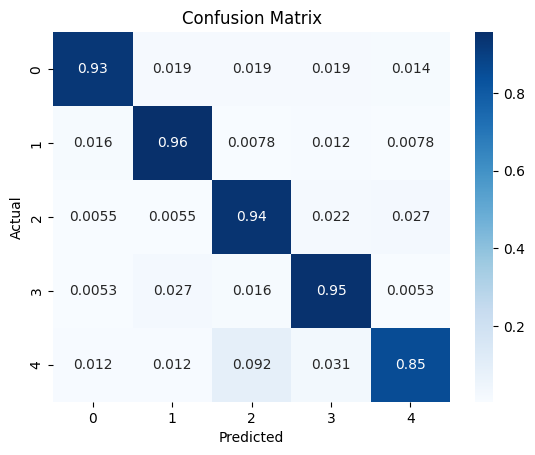

In [37]:
#display on heatmap
cf = confusion_matrix(y_test, pred, normalize="true")
sns.heatmap(cf, annot = True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

End